In [42]:
import numpy as np
from scipy.interpolate import approximate_taylor_polynomial

from scipy import special
import matplotlib.pyplot as plt
from pysrc.optimization import solve_planner_problem
from pysrc.sampling import baseline
from pysrc.services.data_service import load_site_data

In [46]:
r = np.sqrt(240000/ (22/7))

In [48]:
(22/7) * ((r + 10) ** 2)

257684.21046122367

In [3]:
# Model hyperparameters
solver = "gurobi"
pee = 7.6
pa = 41.11
num_sites = 1043
T = 200


(zbar_2017, z_2017, forest_area_2017) = load_site_data(num_sites)

# Set productivity parameters using baseline mean
baseline_fit = baseline.sample(
    num_sites=num_sites,
    iter_sampling=10**3,
    chains=5,
    seed=1,
)

theta = baseline_fit.stan_variable("theta").mean(axis=0)
gamma = baseline_fit.stan_variable("gamma").mean(axis=0)

# Computing carbon absorbed in start period
x_2017 = gamma * forest_area_2017

# Solve planner problem
results = solve_planner_problem(
    x0=x_2017,
    z0=z_2017,
    zbar=zbar_2017,
    gamma=gamma,
    theta=theta,
    time_horizon=T,
    price_cattle=pa,
    price_emissions=pee,
)

12:29:21 - cmdstanpy - INFO - compiling stan file /Users/ph2696/Projects/project-amazon/stan_model/baseline.stan to exe file /Users/ph2696/Projects/project-amazon/stan_model/baseline


Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/calibration/hmc


12:29:28 - cmdstanpy - INFO - compiled model executable: /Users/ph2696/Projects/project-amazon/stan_model/baseline
12:29:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:01 Iteration:   1 / 1000 [  0%]  (Sampling)





chain 1 |█▎        | 00:01 Iteration: 100 / 1000 [ 10%]  (Sampling)





chain 1 |█▊        | 00:02 Iteration: 200 / 1000 [ 20%]  (Sampling)





chain 1 |██▎       | 00:02 Iteration: 300 / 1000 [ 30%]  (Sampling)





chain 1 |██▋       | 00:03 Iteration: 400 / 1000 [ 40%]  (Sampling)





chain 1 |███▏      | 00:03 Iteration: 500 / 1000 [ 50%]  (Sampling)





chain 1 |███▋      | 00:04 Iteration: 600 / 1000 [ 60%]  (Sampling)





chain 1 |████      | 00:05 Iteration: 700 / 1000 [ 70%]  (Sampling)





chain 1 |████▌     | 00:05 Iteration: 800 / 1000 [ 80%]  (Sampling)





chain 1 |█████     | 00:06 Iteration: 900 / 1000 [ 90%]  (Sampling)


chain 1 |██████████| 0


12:29:39 - cmdstanpy - INFO - CmdStan done processing.



Solving the optimization problem...
Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmp7n3kdhyg.pyomo.lp
Reading time = 1.22 seconds
x1: 417600 rows, 834801 columns, 2083271 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 417600 rows, 834801 columns and 2083271 nonzeros
Model fingerprint: 0x116e6e0d
Model has 400 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [7e-04, 1e+03]
  QObjective range [2e+03, 2e+05]
  Bounds range     [3e-06, 1e+00]
  RHS range        [9e-11, 5e-01]
Presolve removed 208947 rows and 209294 columns
Presolve time: 0.39s
Presolved: 208653 rows, 625507 column

# Biodiversity Calculation

Let S denote species, Y denote biomass, and A denote area

We have that
$$
S = cA^z
$$

and 
$$
Y = aS^b
$$

so the relative change in biomass (mediated by a change in species richness) given a changein area from $A$ to $A'$ is


$$
m(A) := \frac{Y'}{Y} = \left( \frac{A'}{A} \right)^{bz}
$$

We can then apply this multiplier to the left-over area $A-A'$ 

In [25]:
Z_agg = results.Z.sum(axis=1)

# Compute forest area at time t
F = (zbar_2017.sum() - Z_agg) * 1e9

In [26]:
b = 0.26
z = 0.25

# Compute area deforested in the first 30 years
D = F[0] - F[30]

In [27]:
biomass_loss = []
A_initial = []
for i in range(10):
    # Set baseline area
    A = F[0] / (i + 1)

    A_initial.append(A)

    # Compute relative change in biomass
    m = (1 - (D / A)) ** (b * z)

    # Compute biomass loss
    biomass_loss.append(copy(m))

In [31]:
(0.5) ** (1 / 16)

0.9576032806985737

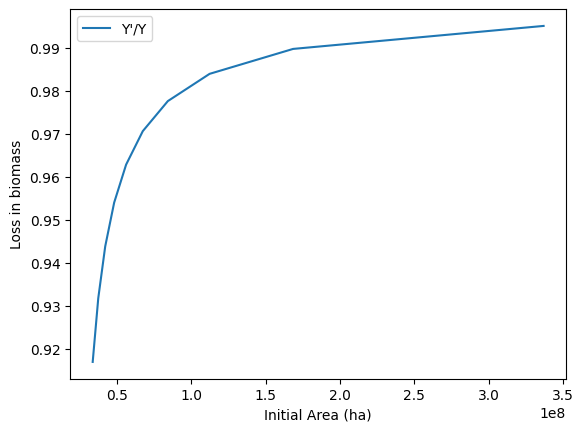

In [28]:
# Plot the result
plt.plot(A_initial, biomass_loss, label="Y'/Y")
plt.xlabel("Initial Area (ha)")
plt.ylabel("Loss in biomass")
plt.legend()
plt.show()

In [38]:
m = (1 - (D / (1.1 * D))) ** (b * z)
m

0.8556762450933418

In [40]:
14*0.1

1.4000000000000001

In [39]:
1-m

0.14432375490665816

In [29]:
D / (10**8)

0.24824650443351925

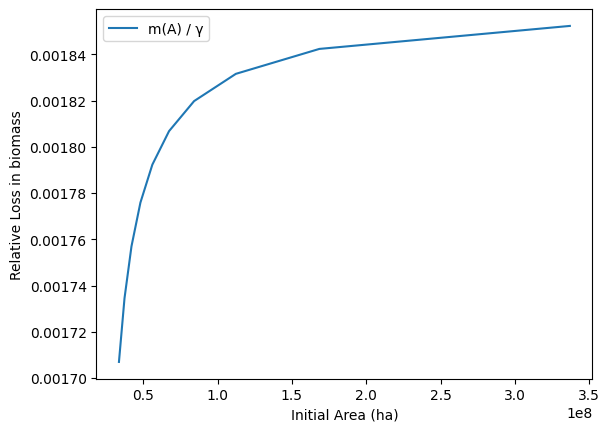

In [24]:
initial_biomass_loss = gamma.mean() * D

relative_biomass_loss = np.array(biomass_loss) / initial_biomass_loss

# Plot the result
plt.plot(A_initial, relative_biomass_loss, label="m(A) / γ")
plt.xlabel("Initial Area (ha)")
plt.ylabel("Relative Loss in biomass")
plt.legend()
plt.show()